In [1]:
from transformers import AutoModelForCausalLM, PreTrainedTokenizerFast, BitsAndBytesConfig, AutoTokenizer
import torch
from matplotlib import pyplot as plt
import numpy as np
from transformers import utils
import llm_attr
import llm_attr_eval
import math
import random
from datasets import load_dataset
from evaluate import load
import json

utils.logging.set_verbosity_error()  # Suppress standard warnings

def load_model(model_name):
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if multi-GPU

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map="cuda", # dispatch efficiently the model on the available ressources
        attn_implementation="eager",
        torch_dtype=torch.float16
    )
    model.eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=True)

    # Needed for LLaMA tokenizer
    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

model_name = "meta-llama/Llama-3.2-1B-Instruct" 
mem_limit = 1400
model, tokenizer = load_model(model_name)

In [2]:
DEFAULT_PROMPT_TEMPLATE = "Context:{context}\n\n\nQuery: {query}"

def model_forward(prompt, model, tokenizer, new_generations = 512, print_response = True):
    modified_prompt = DEFAULT_PROMPT_TEMPLATE.format(context = " " + prompt, query = "")
    formatted_prompt = [{"role": "user", "content": modified_prompt}]
    formatted_prompt = tokenizer.apply_chat_template(
        formatted_prompt,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=False # Switches between thinking and non-thinking modes. Default is True.
    )

    model_input = tokenizer(formatted_prompt, return_tensors="pt", add_special_tokens=False).to("cuda")

    with torch.no_grad():
        # outputs = model.generate(model_input.input_ids, do_sample = False, temperature = 1.0, top_k = 0, top_p = 1.0, num_beams = 1, repetition_penalty = 1.0, max_new_tokens = new_generations)[0]
        outputs = model.generate(model_input.input_ids, do_sample = False, max_new_tokens = new_generations)[0]
        
        # Get only the generated tokens (excluding the prompt)
        generated_ids = outputs[model_input.input_ids.shape[1]:]  # Slice off the prompt
        # print(tokenizer.convert_ids_to_tokens(generated_ids))
        generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
        if print_response:
            print(tokenizer.decode(outputs))
            
    return generated_text

def preprocess_example(example) -> str:
    """
    Converts HotpotQA context to a single string for compatibility with SQuAD.
    """
    # If it's already a string (SQuAD), leave it alone
    if isinstance(example["context"], str):
        return example
    
    # Otherwise, flatten HotpotQA context
    flattened_context = ""
    for title, sentences in zip(example["context"]["title"], example["context"]["sentences"]):
        flattened_context += f"{title}\n"
        flattened_context += "\n".join(sentences) + "\n\n"
    
    example["context"] = flattened_context.strip()
    return example


In [3]:
llm_evaluator = llm_attr_eval.LLMAttributionEvaluator(model, tokenizer)

In [4]:
# # https://huggingface.co/datasets/alabnii/morehopqa

# with open("data/with_human_verification.json", "r") as f:
#     data = json.load(f)

# index = 0
# context = ""
# question = data[index]["question"]
# answer = data[index]["answer"]
# context_len = len(data[index]["context"])
# for i, item in enumerate(data[index]["context"]):
#     context += "".join(item[1])
#     if i != context_len - 1:
#         context += " "

# prompt = context + "\n" + question
# indices_to_explain = [-2]
# target = None

# print(prompt)
# print(answer)

In [5]:
# Math dataset

# https://github.com/kojima-takeshi188/zero_shot_cot/blob/main/dataset/MultiArith/MultiArith.json
# https://github.com/kojima-takeshi188/zero_shot_cot/blob/main/dataset/grade-school-math/test.jsonl


with open('data/math_mine.json', 'r', encoding="utf-8") as f:
    data = json.load(f)

index = 6

dataset_item = data[index]["question"]
answer = data[index]["answer"]
target = None

sentences = llm_attr_eval.create_sentences(dataset_item, tokenizer)
context_sentences = sentences[:-1]
question = sentences[-1][1:]

context_sentences_w_dummy = llm_evaluator.add_dummy_facts_to_prompt(context_sentences)
question_sentences_w_dummy = llm_evaluator.add_dummy_facts_to_prompt([question])
prompt = "".join(context_sentences_w_dummy) + "\n" + "".join(question_sentences_w_dummy)
attr_mask = torch.zeros((1, len(context_sentences_w_dummy) + len(question_sentences_w_dummy)))
attr_mask[:, ::2] = 1
attr_mask_indices = torch.where(attr_mask[0] == 1)[0]
indices_to_explain = [-2]

print(prompt)
print(answer)
print("GT indices", attr_mask_indices)

Eliza's rate per hour for the first 40 hours she works each week is $10. Unrelated Sentence. She also receives an overtime pay of 1.2 times her regular hourly rate. Unrelated Sentence.
If Eliza worked for 45 hours this week, how much are her earnings for this week? Unrelated Sentence.
Eliza is entitled to 45 -40 = <<45-40=5>>5 hours overtime pay.
Her hourly rate for the overtime pay is $10 x 1.2 = $<<10*1.2=12>>12.
So, Eliza will receive $12 x 5 =$<<12*5=60>>60 for overtime pay.
Her regular weekly earning is $10 x 40 = $<<10*40=400>>400.
Thus, Eliza will receive a total of $400 + $60 = $<<400+60=460>>460 for this week's work.
#### 460
GT indices tensor([0, 2, 4])


In [6]:
# # # Facts dataset 

# # # # dataset = load_dataset("fever/feverous")["validation"]

# with open("data/10000_facts_9_choose_3.json", "r") as f:
#     data = json.load(f)

# index = 5
# prompt = data[index]["prompt"]
# target = data[index]["target"]

# generation_indices = data[index]["generation_indices"]
# attr_mask_indices = data[index]["attr_mask_indices"]
# indices_to_explain = data[index]["indices_to_explain"]

# print(prompt)
# print(target)
# print(generation_indices)
# print(attr_mask_indices)
# print(indices_to_explain)

In [7]:
# DO NOT UNCOMMENT THIS BLOCK UNLESS YOU WANT TO REMAKE THE FACTS DATA
# # # # dataset = load_dataset("fever/feverous")["validation"]

# # # # # making a Facts datset # DO NOT UNCOMMENT THIS BLOCK UNLESS YOU WANT TO REMAKE THE DATA
# # # # total = 500
# # # # N = len(dataset)
# # # # M = 5
# # # # K = 3
# # # # L = 2

# # # # json_obj_array = []
# # # # entries_gathered= 0
# # # # with tqdm(total=total) as pbar:
# # # #     while entries_gathered != total:
        
# # # #         # Random N indices for facts selection
# # # #         fact_indices = random.sample(range(N), M)
# # # #         facts = []
# # # #         for idx in fact_indices:
# # # #             fact = dataset[idx]["claim"]
# # # #             if fact[-1] != ".":
# # # #                 fact = fact + "."
# # # #             facts.append(fact)

# # # #         if len(llm_attr_eval.create_sentences(" ".join(facts), tokenizer)) != M:
# # # #             continue

# # # #         generation_indices = torch.sort(torch.randperm(M)[:K])[0]
# # # #         indices_to_explain = torch.sort(torch.randperm(K)[:L])[0]
# # # #         explained_idx_locations = generation_indices[indices_to_explain]
# # # #         prompt = " ".join(facts) + "\nList " + str(K) + " of these facts."
# # # #         target = " ".join([facts[idx] for idx in generation_indices])

# # # #         json_obj_array.append({"prompt": prompt, 
# # # #                             "target": target, 
# # # #                             "generation_indices" : generation_indices.tolist(), 
# # # #                             "indices_to_explain" : indices_to_explain.tolist(),
# # # #                             "attr_mask_indices" : explained_idx_locations.tolist()})

# # # #         entries_gathered += 1
# # # #         pbar.update(1)

# # # # with open('data/' + str(total) + '_facts_' + str(M) + '_choose_' + str (K) + '.json', 'w', encoding='utf-8') as f:
# # # #     json.dump(json_obj_array, f, ensure_ascii=False, indent=4)

In [8]:
new_generations = 512

gen = model_forward(prompt, model, tokenizer, new_generations, print_response=True)

total_gen_len = len(tokenizer(gen, add_special_tokens=False).input_ids)
batch_size = int(math.floor(mem_limit / total_gen_len))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 24 Sep 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

Context: Eliza's rate per hour for the first 40 hours she works each week is $10. Unrelated Sentence. She also receives an overtime pay of 1.2 times her regular hourly rate. Unrelated Sentence.
If Eliza worked for 45 hours this week, how much are her earnings for this week? Unrelated Sentence.


Query:<|eot_id|><|start_header_id|>assistant<|end_header_id|>

To find Eliza's earnings for the week, we need to calculate her regular earnings for the first 40 hours and her overtime earnings.

Regular earnings for the first 40 hours:
40 hours * $10/hour = $400

Overtime earnings:
45 hours - 40 hours = 5 hours
Overtime rate: 1.2 times regular rate = 1.2 * $10/hour = $12/hour
5 hours * $12/hour = $60

Total earnings for the week:
Regular earnings + Overtime earnings = $400 + $60 = $460

Therefore, Eliza's earnings for thi

In [9]:
# plt.rcParams['font.size'] = 10

# IG attribution
# llm_attributor = llm_attr.LLMGradientAttribtion(model, tokenizer)

# attr = llm_attributor.calculate_IG_per_generation(prompt, 20, baseline = tokenizer.eos_token_id, batch_size = 1, target = target)

# attrs = attr.get_all_sentence_attrs(indices_to_explain)

In [10]:
plt.rcParams['font.size'] = 10

llm_attributor = llm_attr.LLMPerturbationAttribution(model, tokenizer)

# perturbation attribution
attr = llm_attributor.calculate_feature_ablation_sentences(prompt, baseline = tokenizer.eos_token_id, target = target)

# CLP attribution
# attr = llm_attributor.calculate_feature_ablation_sentences(prompt, baseline = tokenizer.eos_token_id, measure="KL", target = target)

# ReAGent attribution
# attr = llm_attributor.calculate_feature_ablation_sentences_mlm(prompt, target = target)

attrs = attr.get_all_sentence_attrs(indices_to_explain)

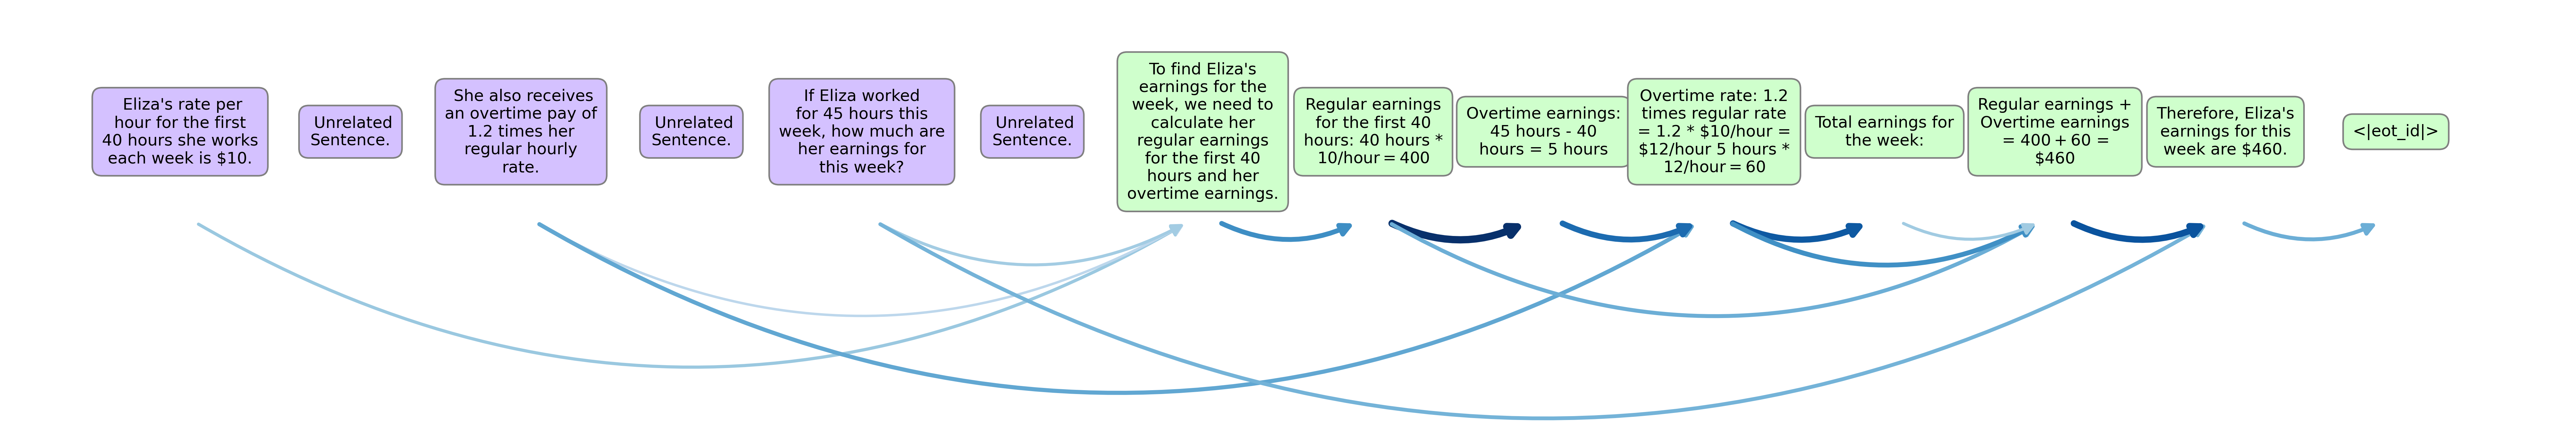

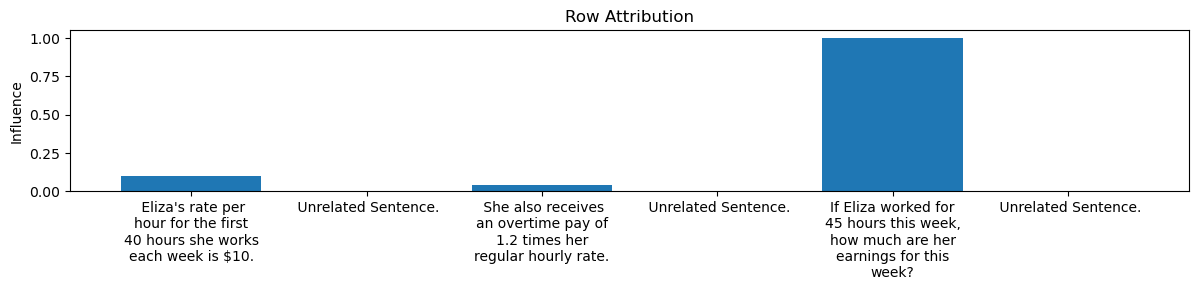

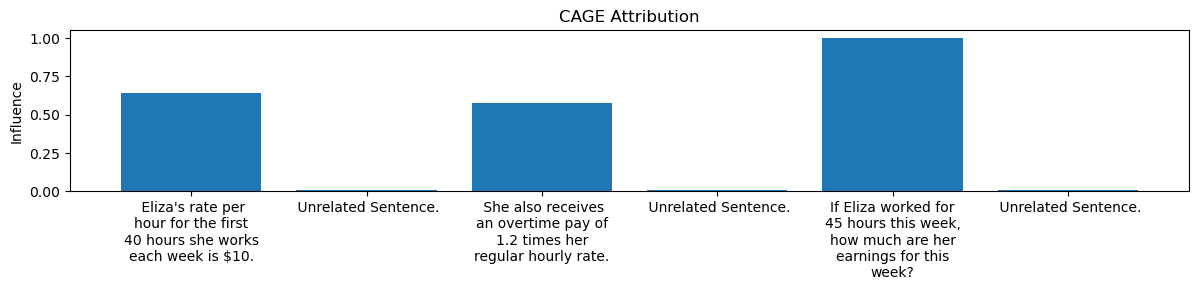

In [11]:
plt.rcParams['font.size'] = 10

new_attr = llm_attr.LLMAttributionResult(tokenizer, attr.attribution_matrix, attr.prompt_tokens, attr.generation_tokens, attr.all_tokens)
new_attr.compute_sentence_attr(norm = False)

# new_attr.plot_attr_table_sentence()

og = new_attr.sentence_attr.clone()

thresh = 0.25
new_attr.draw_graph(cmap = plt.cm.Blues, wrap_width=18, thresh = thresh, spacing = 3.2, arrow_mod=0.3, rad = 0.3)

new_attr.sentence_attr = attrs[1]
new_attr.plot_context_attr_sentence("Row Attribution")

new_attr.sentence_attr = attrs[2]
new_attr.plot_context_attr_sentence("CAGE Attribution")

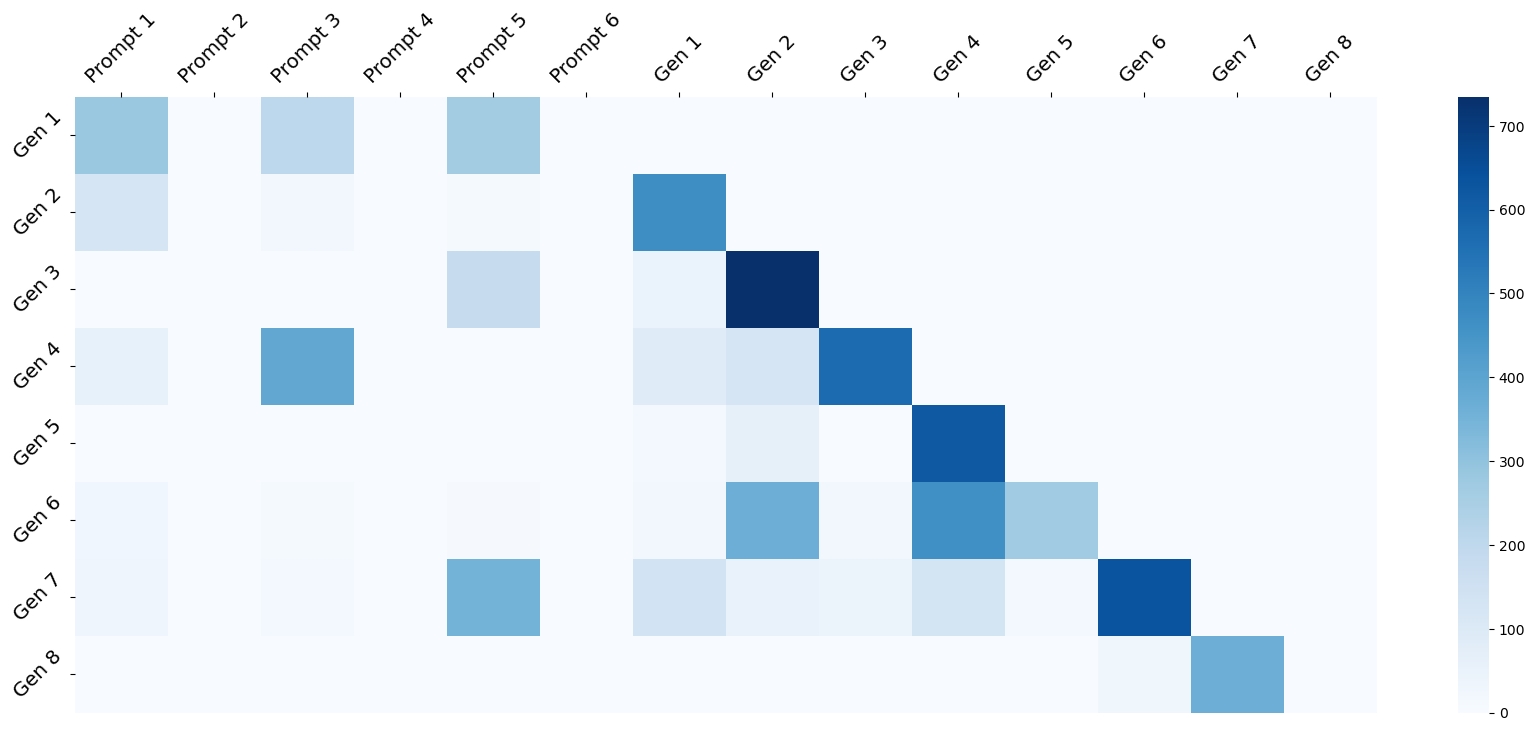

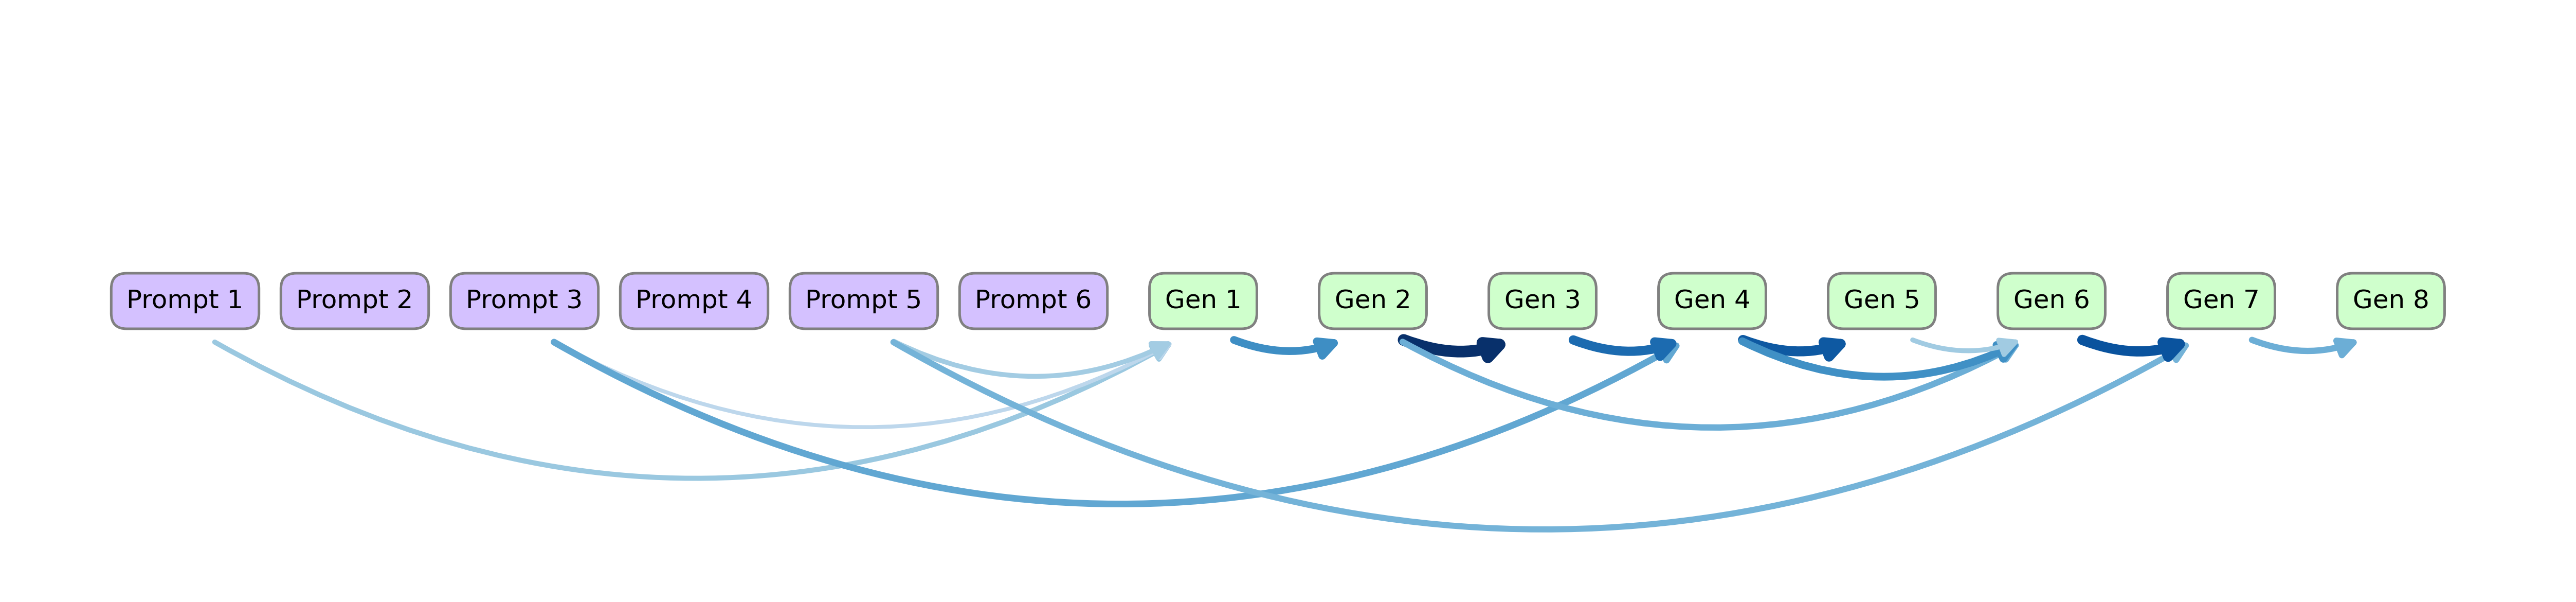

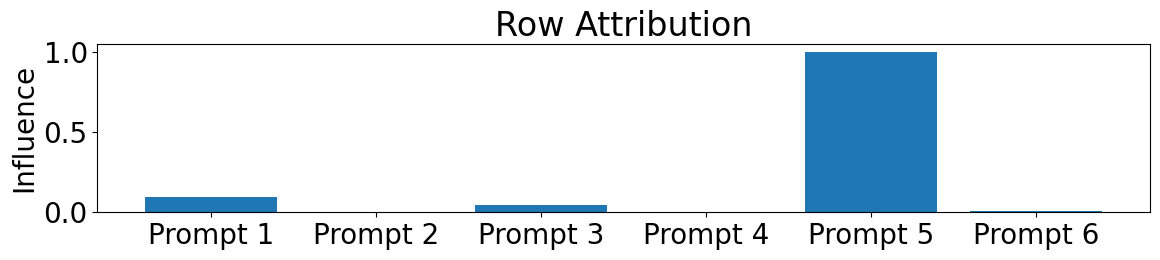

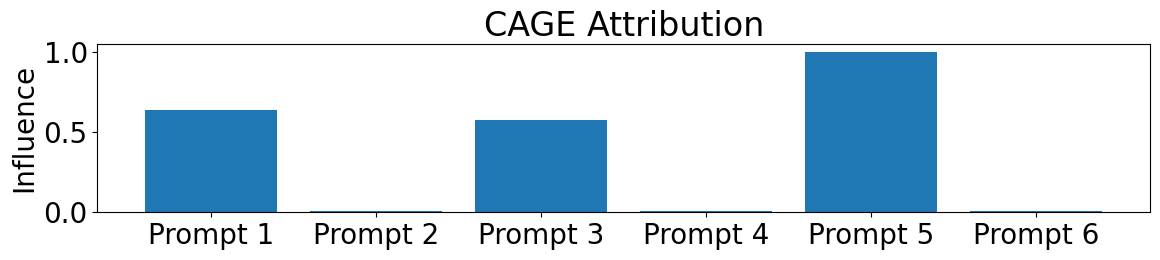

In [12]:
# printing as prompt x and gen y

all_sentences = []
for i in range(len(attr.prompt_sentences)):
    all_sentences.append("Prompt " + str(i + 1))

generation_sentences = []
for i in range(len(attr.generation_sentences)):
    all_sentences.append("Gen " + str(i + 1))
    generation_sentences.append("Gen " + str(i + 1))


new_attr = llm_attr.LLMAttributionResult(tokenizer, attr.attribution_matrix, attr.prompt_tokens, attr.generation_tokens, attr.all_tokens)
new_attr.compute_sentence_attr(norm = False)

new_attr.generation_sentences = generation_sentences
new_attr.all_sentences = all_sentences
new_attr.prompt_sentences = all_sentences[:len(new_attr.prompt_sentences)]

new_attr.plot_attr_table_sentence()

og = new_attr.sentence_attr.clone()

thresh = 0.25
new_attr.draw_graph(cmap = plt.cm.Blues, wrap_width=18, thresh = thresh, spacing = 2, arrow_mod=0.3, rad = 0.3)

plt.rcParams['font.size'] = 20

new_attr.sentence_attr = attrs[1]
new_attr.plot_context_attr_sentence("Row Attribution")

new_attr.sentence_attr = attrs[2]
new_attr.plot_context_attr_sentence("CAGE Attribution")